<a href="https://colab.research.google.com/github/andrewli2403/compressor/blob/main/stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.6 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from transformers import CLIPTextModel, CLIPTokenizer

pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"

vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet")
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [ ]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features

In [ ]:
import PIL
import numpy as np

height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
generator = torch.manual_seed(0)

def resize_to_512(input_file, output_file):
  img = Image.open(input_file).convert('RGB')
  #center crop image
  maxdim = max(img.width, img.height)
  mindim = min(img.width, img.height)
  left = max(0, (img.width - img.height) // 2 - 1)
  top = max(0, (img.height - img.width) // 2 - 1)
  img = img.crop((left, top, left + mindim - 1, top + mindim - 1))
  #resize
  img = img.resize((512,512), Image.LANCZOS)
  print(img)
  img.save(output_file, lossless = True, quality = 100)

#load image from path to torch array
def load_img(path):
    image = Image.open(path).convert("RGB")
    # Convert the image to a numpy array
    image_array = np.array(image)

    # Print the shape of the array
    print(image_array.shape)
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

#convert torch array to latent representation for vae
def to_latent(torch_img):
  with torch.no_grad():
    latents = vae.encode(torch_img.to(vae.dtype).to(torch_device))
    latents = latents.latent_dist.sample(generator=generator)
  return latents * .18215

#convert latent representatino for vae to image object
def to_img(latents):
  latents = latents / .18125
  with torch.no_grad():
    torch_img = vae.decode(latents.to(vae.dtype).to(torch_device)).sample

  torch_img = (torch_img / 2 + 0.5).clamp(0, 1)
  np_img = torch_img.detach().cpu().permute(0, 2, 3, 1).numpy()[0]
  np_img = (np_img * 255.0).round().astype("uint8")
  img = Image.fromarray(np_img)
  return img

#computes loss of ground truth and latent representation of vae
from skimage.metrics import mean_squared_error
def loss(truth, latents):
  return mean_squared_error(np.array(truth), np.array(to_img(latents)))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# resizing
resize_to_512("/content/drive/MyDrive/nasa/nn_compression/matt.jpg", "/content/drive/MyDrive/nasa/nn_compression/test.jpg")

<PIL.Image.Image image mode=RGB size=512x512 at 0x796552DE9570>


In [ ]:
from PIL import Image
image_path = "/content/drive/MyDrive/nasa/nn_compression/test.jpg"
ground_truth = Image.open(image_path)

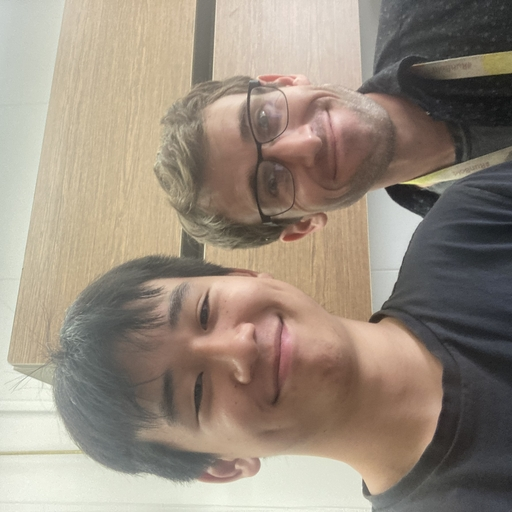

In [ ]:
ground_truth

(array([  3627.,  53227.,  95225., 114210.,  93205.,  84979.,  81024.,
        127908., 106067.,  26960.]),
 array([  5.,  30.,  55.,  80., 105., 130., 155., 180., 205., 230., 255.]),
 <BarContainer object of 10 artists>)

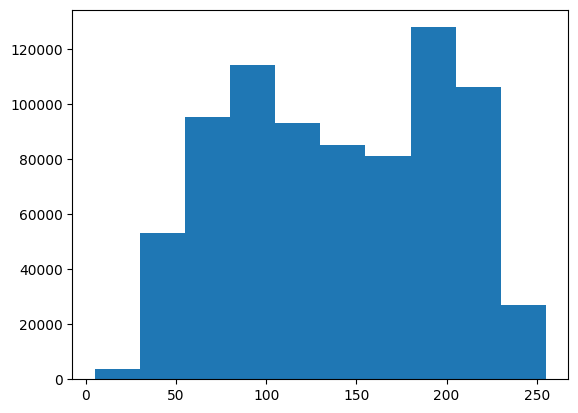

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
plt.hist(np.array(ground_truth).flatten())

In [ ]:
import numpy as np
def calculate_entropy(image):
    # Compute the histogram of the grayscale image
    histogram, _ = np.histogram(np.array(image).flatten(), bins=256, range=[0, 256])

    # Normalize the histogram to get probabilities of each intensity level
    probabilities = histogram / float(np.sum(histogram))

    # Calculate the entropy using the probabilities
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))

    return entropy

In [ ]:
calculate_entropy(ground_truth)

7.693463648816293

(512, 512, 3)
loaded input image of size (512, 512) from /content/drive/MyDrive/nasa/nn_compression/test.jpg
28.32919692993164


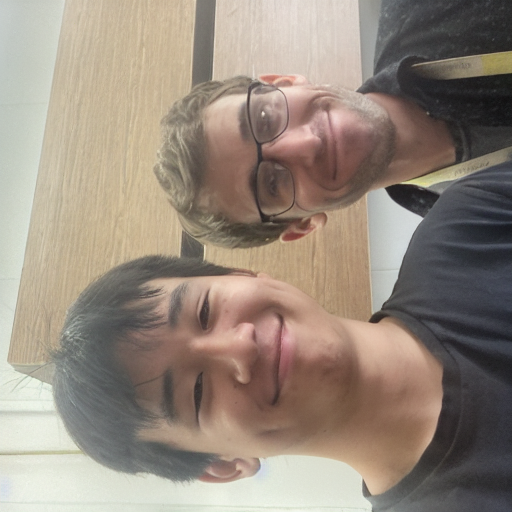

In [ ]:
latents = to_latent(load_img(image_path))
latents.shape
print(loss(ground_truth, latents))
to_img(latents)

In [ ]:
torch.min(latents), torch.max(latents)

(tensor(-2.9382, device='cuda:0'), tensor(4.1806, device='cuda:0'))

In [ ]:
latents.dtype

torch.float32

In [ ]:
def quantize(latents):
  #uniform buckets
  return 0


In [ ]:
import inspect

#leave text encoder as empty by default
uncond_input = tokenizer([""], padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

@torch.no_grad()
def denoise(latents):
  num_inference_steps = 50

  #inpainting - prevent overfitting
  strength = 0.04

  # set timesteps
  accepts_offset = "offset" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
  extra_set_kwargs = {}
  offset = 0
  if accepts_offset:
      offset = 1
      extra_set_kwargs["offset"] = 1

  scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

  # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
  # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
  # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
  # and should be between [0, 1]
  eta = 0.0
  accepts_eta = "eta" in set(inspect.signature(scheduler.step).parameters.keys())
  extra_step_kwargs = {}
  if accepts_eta:
      extra_step_kwargs["eta"] = eta

  init_timestep = int(num_inference_steps * strength) + offset
  init_timestep = min(init_timestep, num_inference_steps)
  t_start = max(num_inference_steps - init_timestep + offset, 0)

  #min_loss = float('inf')
  input = latents

  for t in scheduler.timesteps[t_start:]:
    with torch.no_grad():
      noisy_residual = unet(input, t, encoder_hidden_states=uncond_embeddings).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input, **extra_step_kwargs).prev_sample

    print(loss(ground_truth, input))
    input = previous_noisy_sample

    #finds optimal picture within 50 timesteps
    #if (loss(ground_truth, input) < min_loss):
      #min_loss = loss(ground_truth, input)
      #optimal = input

  return input

28.32916514078776
28.09856669108073
27.94759750366211


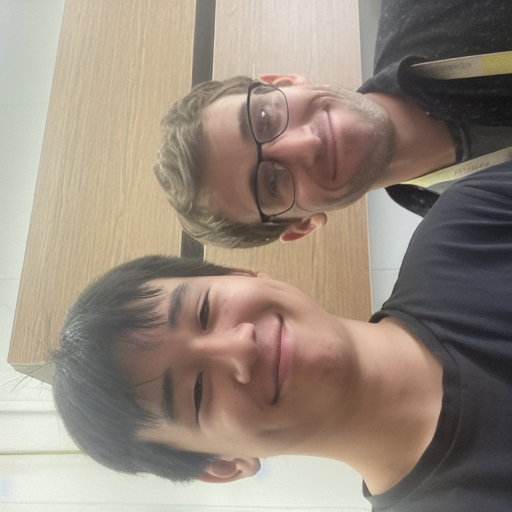

In [ ]:
image = to_img(denoise(latents))
image

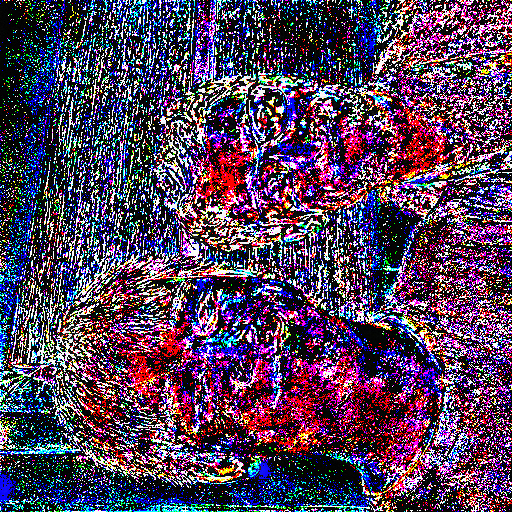

In [ ]:
residual = np.array(ground_truth).astype("float") - np.array(image).astype("float")
Image.fromarray(np.array(ground_truth)-np.array(image))

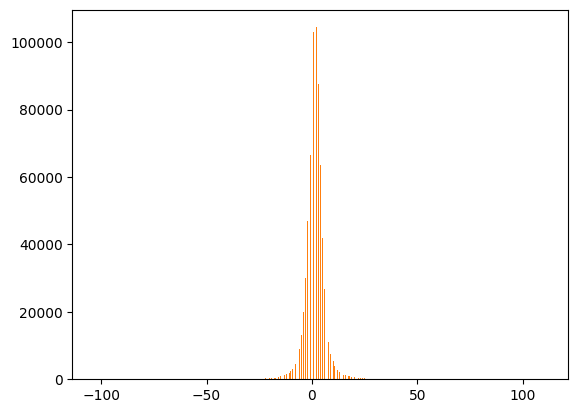

In [ ]:
number_of_counts = plt.hist(residual.flatten().astype("float"), bins=512)[0]
center = plt.hist(residual.flatten().astype("float"), bins=512)[1]

In [ ]:
number_of_counts = number_of_counts[np.where(number_of_counts > 0)]
number_of_counts = number_of_counts / sum(number_of_counts)
np.sum(-number_of_counts * np.log2(number_of_counts))

4.039650370606205